# GoodsForecast.OSA – Определение наличия товаров на полке в интервалах без продаж

## Сборная команда №3

### Направление 1

## Описание кейса

**Система GoodsForecast.OSA** анализирует историю продаж в сети магазинов и определяет товары с наибольшей вероятностью отсутствия на полке.
- Сотрудники магазинов по каждой позиции проверяют наличие товара и корректность ценника, при необходимости выставляя продукцию со склада и/или корректируя ценник.
- Таким образом, мы стремимся обеспечить своевременное обнаружение отсутствия товаров на полке, чтобы покупатели не упустили возможность совершить покупку, а сеть повысила товарооборот. 
 
*OSA (On  Shelf Availability) – показатель представленности продукции на полке магазина.*

## Задача
* Необходимо решить задачу бинарной классификации – определение наличия товаров на полке в интервалах без продаж с оценкой производительности по метрике AUC-ROC.
* Направление 1: Построить модель без использования оценки вероятности отсутствия товара на полке (Probability), представленной в витрине данных.

## Оценка решения

- Решение оценивается на основе метрики AUC-ROC на скрытой тестовой выборке.

## Формат выгрузки csv-файла (столбцы):
### Для чек-поинтов - это на тренировочных данных, для финального резульата - на тестовых данных

1.   LocationId
2.   ProductId
3.   ValidationDateTime
4.   CalculatedProbability (вычисленная вами вероятность - predict_proba() )

# Импорты необходимых билиотек

In [1]:
#!pip install holidays 

In [2]:
import pyodbc
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix


# импорт моделей 
from catboost import CatBoostClassifier

# предварительная обработка
from sklearn.preprocessing import (
    TargetEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_predict
)

from sklearn.impute import KNNImputer

# метрики
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    roc_curve, auc, 
    f1_score
)

# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 42

# Загрузка данных из витрины

In [3]:
#!pip install holidays 

In [4]:
import pyodbc
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix
from sklearn.cluster import KMeans

# импорт моделей 
from catboost import CatBoostClassifier
import lightgbm as lgb

# предварительная обработка
from sklearn.preprocessing import (
    TargetEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_predict
)

# метрики
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    roc_curve, auc, 
    f1_score
)

# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 42

# Локальная загрузка

In [5]:
df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\Features_202310201930.csv', sep=',')
#train_df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\train_df.csv', sep=',')
#test_df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\test_df.csv', sep=',')
#stocks = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\LocationStateStocks_202310201937.csv', sep=',')
#sales = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\LocationStateHourSales_202310201931.csv', sep=',')

In [6]:
# весь датасет признаков
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07.000,0.416474,0.0,86.0,85.0,0.011628,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
1,63,288606,2023-06-01 15:32:31.000,0.687710,0.0,8.0,7.0,0.125000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
2,63,288606,2023-06-03 12:55:49.000,0.810383,0.0,10.0,9.0,0.100000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
3,63,288606,2023-06-07 14:57:38.000,0.312500,0.0,4.0,3.0,0.250000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
4,63,288606,2023-06-09 14:56:35.000,0.605429,0.0,6.0,5.0,0.166667,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12 15:17:30.000,0.542776,1.0,1.0,0.0,1.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176614,2950,576631,2023-07-15 15:02:34.000,0.497054,1.0,4.0,4.0,0.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176615,2950,576631,2023-07-26 15:01:27.000,0.930926,NaN,1.0,0.0,1.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176616,2950,576631,2023-07-28 15:04:19.000,0.704421,NaN,3.0,2.0,0.333333,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0


In [7]:
# тренировочный признаков IsCorrect is not null
#train_df

In [8]:
# тестовая выборка используется в финальном зачете - записи с IsCorrect is null
#test_df

# Предварительное изучение данных

In [9]:
# минимальная и максимальная даты
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])
max_date = df['ValidationDateTime'].dt.date.max()
min_date = df['ValidationDateTime'].dt.date.min()
print("Минимальная дата:", min_date)
print("Максимальная дата:", max_date)

Минимальная дата: 2023-06-01
Максимальная дата: 2023-08-04


In [10]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head(5))
    display(data.tail(5))
    data.info()
    display(data.describe())
    print('\nРазмер таблицы:', data.shape)
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков в таблице:', data.isna().sum().sum())

In [11]:
get_info(df)

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,0.0,86.0,85.0,0.011628,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,0.0,8.0,7.0,0.125000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
2,63,288606,2023-06-03 12:55:49,0.810383,0.0,10.0,9.0,0.100000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,0.0,4.0,3.0,0.250000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,0.0,6.0,5.0,0.166667,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0


,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
176613,2950,576631,2023-07-12 15:17:30,0.542776,1.0,1.0,0.0,1.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176614,2950,576631,2023-07-15 15:02:34,0.497054,1.0,4.0,4.0,0.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176615,2950,576631,2023-07-26 15:01:27,0.930926,NaN,1.0,0.0,1.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176616,2950,576631,2023-07-28 15:04:19,0.704421,NaN,3.0,2.0,0.333333,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
176617,2950,576631,2023-07-31 15:06:58,0.502083,NaN,6.0,6.0,0.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176618 entries, 0 to 176617
Data columns (total 66 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          176618 non-null  int64         
 1   ProductId           176618 non-null  int64         
 2   ValidationDateTime  176618 non-null  datetime64[ns]
 3   Probability         176305 non-null  float64       
 4   IsCorrect           135847 non-null  float64       
 5   Column6             176618 non-null  float64       
 6   Column7             176618 non-null  float64       
 7   Column8             141486 non-null  float64       
 8   Column9             0 non-null       float64       
 9   Column10            0 non-null       float64       
 10  Column11            176618 non-null  float64       
 11  Column12            176618 non-null  int64         
 12  Column13            45863 non-null   float64       
 13  Column14            176617 no

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
count,176618.000000,176618.000000,176618,176305.000000,135847.000000,176618.000000,176618.000000,141486.000000,0.0,0.0,...,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,0.0,176617.0
mean,1654.755591,423817.321847,2023-07-07 05:56:16.473903872,0.650315,0.229597,5.281319,4.383947,0.341128,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
min,63.000000,288312.000000,2023-06-01 14:44:35.147000,-1.000000,0.000000,0.000000,-2.000000,0.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
25%,872.000000,361374.000000,2023-06-23 14:59:57,0.441461,0.000000,1.000000,0.000000,0.076923,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
50%,1719.000000,425916.000000,2023-07-08 15:02:33,0.724501,0.000000,3.000000,2.000000,0.200000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
75%,2553.000000,485473.000000,2023-07-21 14:57:17,0.959632,0.000000,6.000000,5.000000,0.500000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
max,2950.000000,576760.000000,2023-08-04 17:08:37.393000,1.000000,1.000000,90.000000,90.000000,2.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
std,893.324832,79493.656830,NaN,0.348815,0.420575,8.960510,8.961102,0.370759,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0



Размер таблицы: (176618, 66)

Количество явных дубликатов: 0

Количество пропусков в таблице: 1287061


In [12]:
def research(data, name, figsize, silent):
    # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {numeric_data.shape}')
    print(f'Количество явных дубликатов: {numeric_data.duplicated().sum()}')
    print(f'Наличие пропусков:           {numeric_data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')
    
    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(numeric_data.isna().mean()*100).sort_values(ascending=False).head(15))
    
    if not silent:
        print(f'\nПроверка структуры {name}:')
        numeric_data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распределения {name}', y=0.95, fontsize=12)
        plt.show()
    
    if silent:
        print(f'Корреляция {name}')
        display(numeric_data.corr().round(3)\
                .style\
                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))
    
    display(numeric_data.describe())

    if not silent:
        display(data.head(5))

Размер данных:      (176618, 65)
Количество явных дубликатов: 121
Наличие пропусков:           1287061
Пропущенные данные (в процентном соотношении):
Column66     100.0
Column26     100.0
Column9      100.0
Column10     100.0
Column13      74.0
Column22      69.0
Column20      69.0
Column28      49.0
IsCorrect     23.0
Column8       20.0
Column21      19.0
Column51       1.0
Column44       1.0
Column50       1.0
Column46       1.0
dtype: float64

Проверка структуры Основные данные:


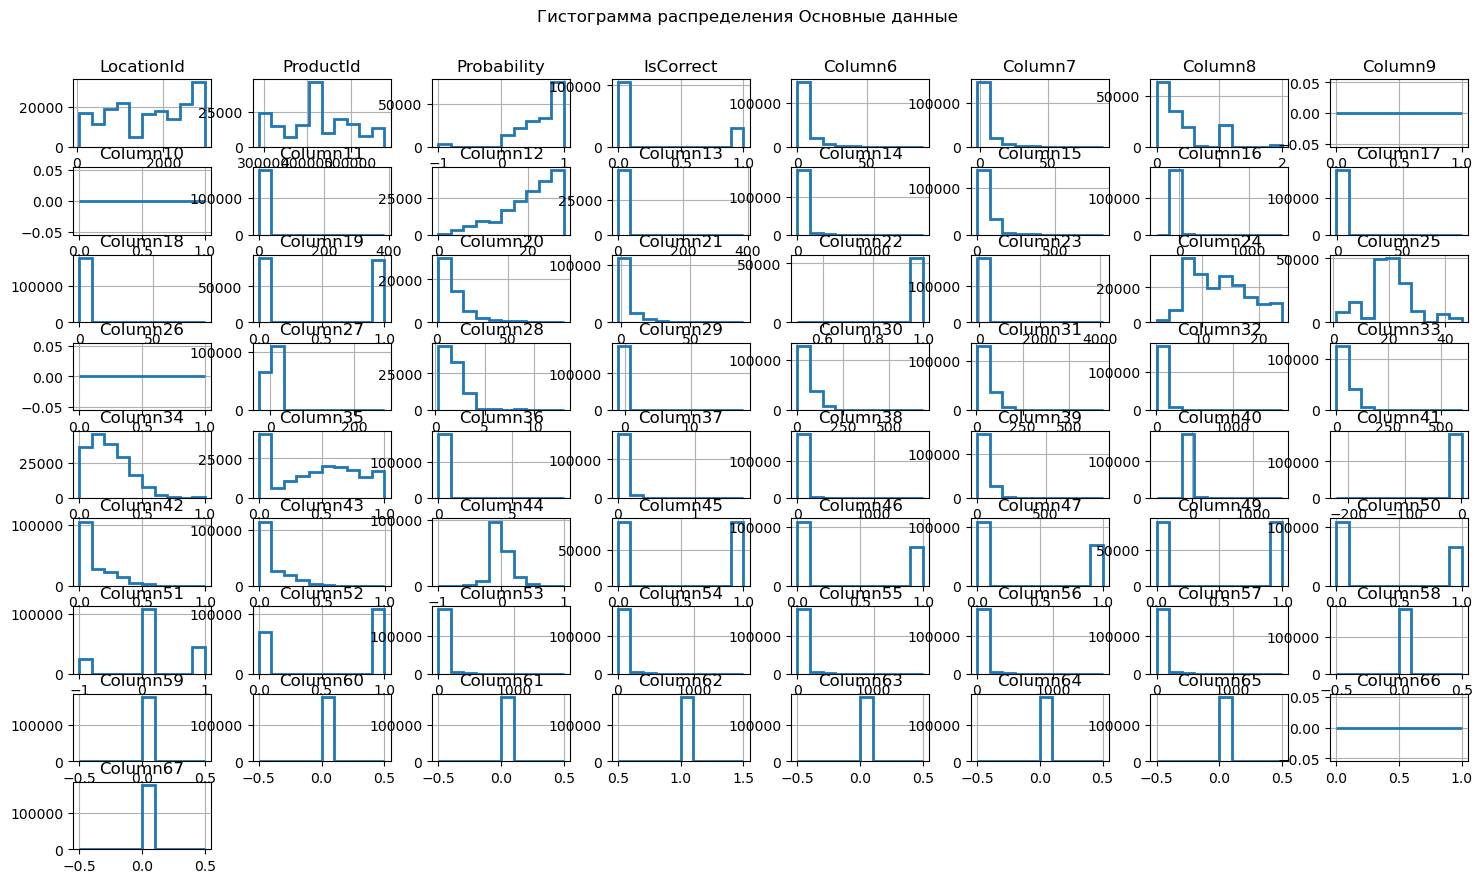

,LocationId,ProductId,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
count,176618.000000,176618.000000,176305.000000,135847.000000,176618.000000,176618.000000,141486.000000,0.0,0.0,176618.000000,...,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,0.0,176617.0
mean,1654.755591,423817.321847,0.650315,0.229597,5.281319,4.383947,0.341128,NaN,NaN,4.305674,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
std,893.324832,79493.656830,0.348815,0.420575,8.960510,8.961102,0.370759,NaN,NaN,4.236874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
min,63.000000,288312.000000,-1.000000,0.000000,0.000000,-2.000000,0.000000,NaN,NaN,0.035714,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
25%,872.000000,361374.000000,0.441461,0.000000,1.000000,0.000000,0.076923,NaN,NaN,2.214286,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
50%,1719.000000,425916.000000,0.724501,0.000000,3.000000,2.000000,0.200000,NaN,NaN,3.464286,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
75%,2553.000000,485473.000000,0.959632,0.000000,6.000000,5.000000,0.500000,NaN,NaN,5.178571,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
max,2950.000000,576760.000000,1.000000,1.000000,90.000000,90.000000,2.000000,NaN,NaN,386.107150,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0


,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,0.0,86.0,85.0,0.011628,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,0.0,8.0,7.0,0.125000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
2,63,288606,2023-06-03 12:55:49,0.810383,0.0,10.0,9.0,0.100000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,0.0,4.0,3.0,0.250000,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,0.0,6.0,5.0,0.166667,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0


In [13]:
research(df, 'Основные данные', figsize=(18, 10), silent=False)

# Создадим новые признаки

In [14]:
import holidays

# календарь праздников РФ
rus_holidays = holidays.Russia()

# определение является ли день праздником или выходным
def is_holiday_or_weekend(date):
    return date in rus_holidays or date.weekday() >= 5  # выходные (суббота и воскресенье) имеют код 5 и 6

# даты в datetime
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])

# столбец "Holidays" с признаком праздника
df['Holidays'] = df['ValidationDateTime'].apply(is_holiday_or_weekend)
df['Holidays'] = df['Holidays'].astype(int)

In [15]:
# добавим новые признаки - минута, час, день недели, неделя, месяц
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])
df['Minute'] = df['ValidationDateTime'].dt.minute
df['Day'] = df['ValidationDateTime'].dt.day
df['Hour'] = df['ValidationDateTime'].dt.hour
df['Weekday'] = df['ValidationDateTime'].dt.weekday
df['Week'] = df['ValidationDateTime'].dt.isocalendar().week
#df['Month'] = df['ValidationDateTime'].dt.month

In [16]:
df['ValidationDateTime'] = df['ValidationDateTime'].dt.date
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column64,Column65,Column66,Column67,Holidays,Minute,Day,Hour,Weekday,Week
0,63,288527,2023-06-28,0.416474,0.0,86.0,85.0,0.011628,NaN,NaN,...,0.0,0.0,NaN,0.0,0,57,28,14,2,26
1,63,288606,2023-06-01,0.687710,0.0,8.0,7.0,0.125000,NaN,NaN,...,0.0,0.0,NaN,0.0,0,32,1,15,3,22
2,63,288606,2023-06-03,0.810383,0.0,10.0,9.0,0.100000,NaN,NaN,...,0.0,0.0,NaN,0.0,1,55,3,12,5,22
3,63,288606,2023-06-07,0.312500,0.0,4.0,3.0,0.250000,NaN,NaN,...,0.0,0.0,NaN,0.0,0,57,7,14,2,23
4,63,288606,2023-06-09,0.605429,0.0,6.0,5.0,0.166667,NaN,NaN,...,0.0,0.0,NaN,0.0,0,56,9,14,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12,0.542776,1.0,1.0,0.0,1.000000,NaN,NaN,...,0.0,0.0,NaN,0.0,0,17,12,15,2,28
176614,2950,576631,2023-07-15,0.497054,1.0,4.0,4.0,0.000000,NaN,NaN,...,0.0,0.0,NaN,0.0,1,2,15,15,5,28
176615,2950,576631,2023-07-26,0.930926,NaN,1.0,0.0,1.000000,NaN,NaN,...,0.0,0.0,NaN,0.0,0,1,26,15,2,30
176616,2950,576631,2023-07-28,0.704421,NaN,3.0,2.0,0.333333,NaN,NaN,...,0.0,0.0,NaN,0.0,0,4,28,15,4,30


In [17]:
# функция для подсчета пропусков в столбцах в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm')
        )
    else:
        print('Пропусков нет')

In [18]:
lost(df)

,Пропуски
Column9,100.000000
Column10,100.000000
Column66,100.000000
Column26,100.000000
Column13,74.033000
Column20,68.696000
Column22,68.696000
Column28,49.441000
IsCorrect,23.084000
Column8,19.892000


In [19]:
# удалим столбцы в которых 100% пропусков
df = df.drop(['Column9','Column10','Column66','Column26'], axis=1) #, 'Column13','Column20','Column22' ], axis=1)

In [20]:
#  True на 1 и False на 0 
df['IsCorrect'] = df['IsCorrect'].replace({True: 1, False: 0})
df['Column19'] = df['Column19'].replace({True: 1, False: 0})

In [21]:
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column11,Column12,...,Column63,Column64,Column65,Column67,Holidays,Minute,Day,Hour,Weekday,Week
0,63,288527,2023-06-28,0.416474,0.0,86.0,85.0,0.011628,0.142857,2,...,0.0,0.0,0.0,0.0,0,57,28,14,2,26
1,63,288606,2023-06-01,0.687710,0.0,8.0,7.0,0.125000,3.714286,19,...,0.0,0.0,0.0,0.0,0,32,1,15,3,22
2,63,288606,2023-06-03,0.810383,0.0,10.0,9.0,0.100000,3.214286,19,...,0.0,0.0,0.0,0.0,1,55,3,12,5,22
3,63,288606,2023-06-07,0.312500,0.0,4.0,3.0,0.250000,3.178571,19,...,0.0,0.0,0.0,0.0,0,57,7,14,2,23
4,63,288606,2023-06-09,0.605429,0.0,6.0,5.0,0.166667,3.035714,19,...,0.0,0.0,0.0,0.0,0,56,9,14,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12,0.542776,1.0,1.0,0.0,1.000000,4.285714,27,...,0.0,0.0,0.0,0.0,0,17,12,15,2,28
176614,2950,576631,2023-07-15,0.497054,1.0,4.0,4.0,0.000000,4.071429,27,...,0.0,0.0,0.0,0.0,1,2,15,15,5,28
176615,2950,576631,2023-07-26,0.930926,NaN,1.0,0.0,1.000000,3.571429,28,...,0.0,0.0,0.0,0.0,0,1,26,15,2,30
176616,2950,576631,2023-07-28,0.704421,NaN,3.0,2.0,0.333333,3.607143,28,...,0.0,0.0,0.0,0.0,0,4,28,15,4,30


## Построим корреляционную матрицу для смешанного набора признаков

In [22]:
numeric = df[df.select_dtypes(include='number').columns]

In [23]:
categorical = df[df.select_dtypes(include='object').columns]

In [24]:
numeric.columns

Index(['LocationId', 'ProductId', 'Probability', 'IsCorrect', 'Column6',
       'Column7', 'Column8', 'Column11', 'Column12', 'Column13', 'Column14',
       'Column15', 'Column16', 'Column17', 'Column18', 'Column19', 'Column20',
       'Column21', 'Column22', 'Column23', 'Column24', 'Column25', 'Column27',
       'Column28', 'Column29', 'Column30', 'Column31', 'Column32', 'Column33',
       'Column34', 'Column35', 'Column36', 'Column37', 'Column38', 'Column39',
       'Column40', 'Column41', 'Column42', 'Column43', 'Column44', 'Column45',
       'Column46', 'Column47', 'Column49', 'Column50', 'Column51', 'Column52',
       'Column53', 'Column54', 'Column55', 'Column56', 'Column57', 'Column58',
       'Column59', 'Column60', 'Column61', 'Column62', 'Column63', 'Column64',
       'Column65', 'Column67', 'Holidays', 'Minute', 'Day', 'Hour', 'Weekday',
       'Week'],
      dtype='object')

In [25]:
categorical.columns

Index(['ValidationDateTime'], dtype='object')

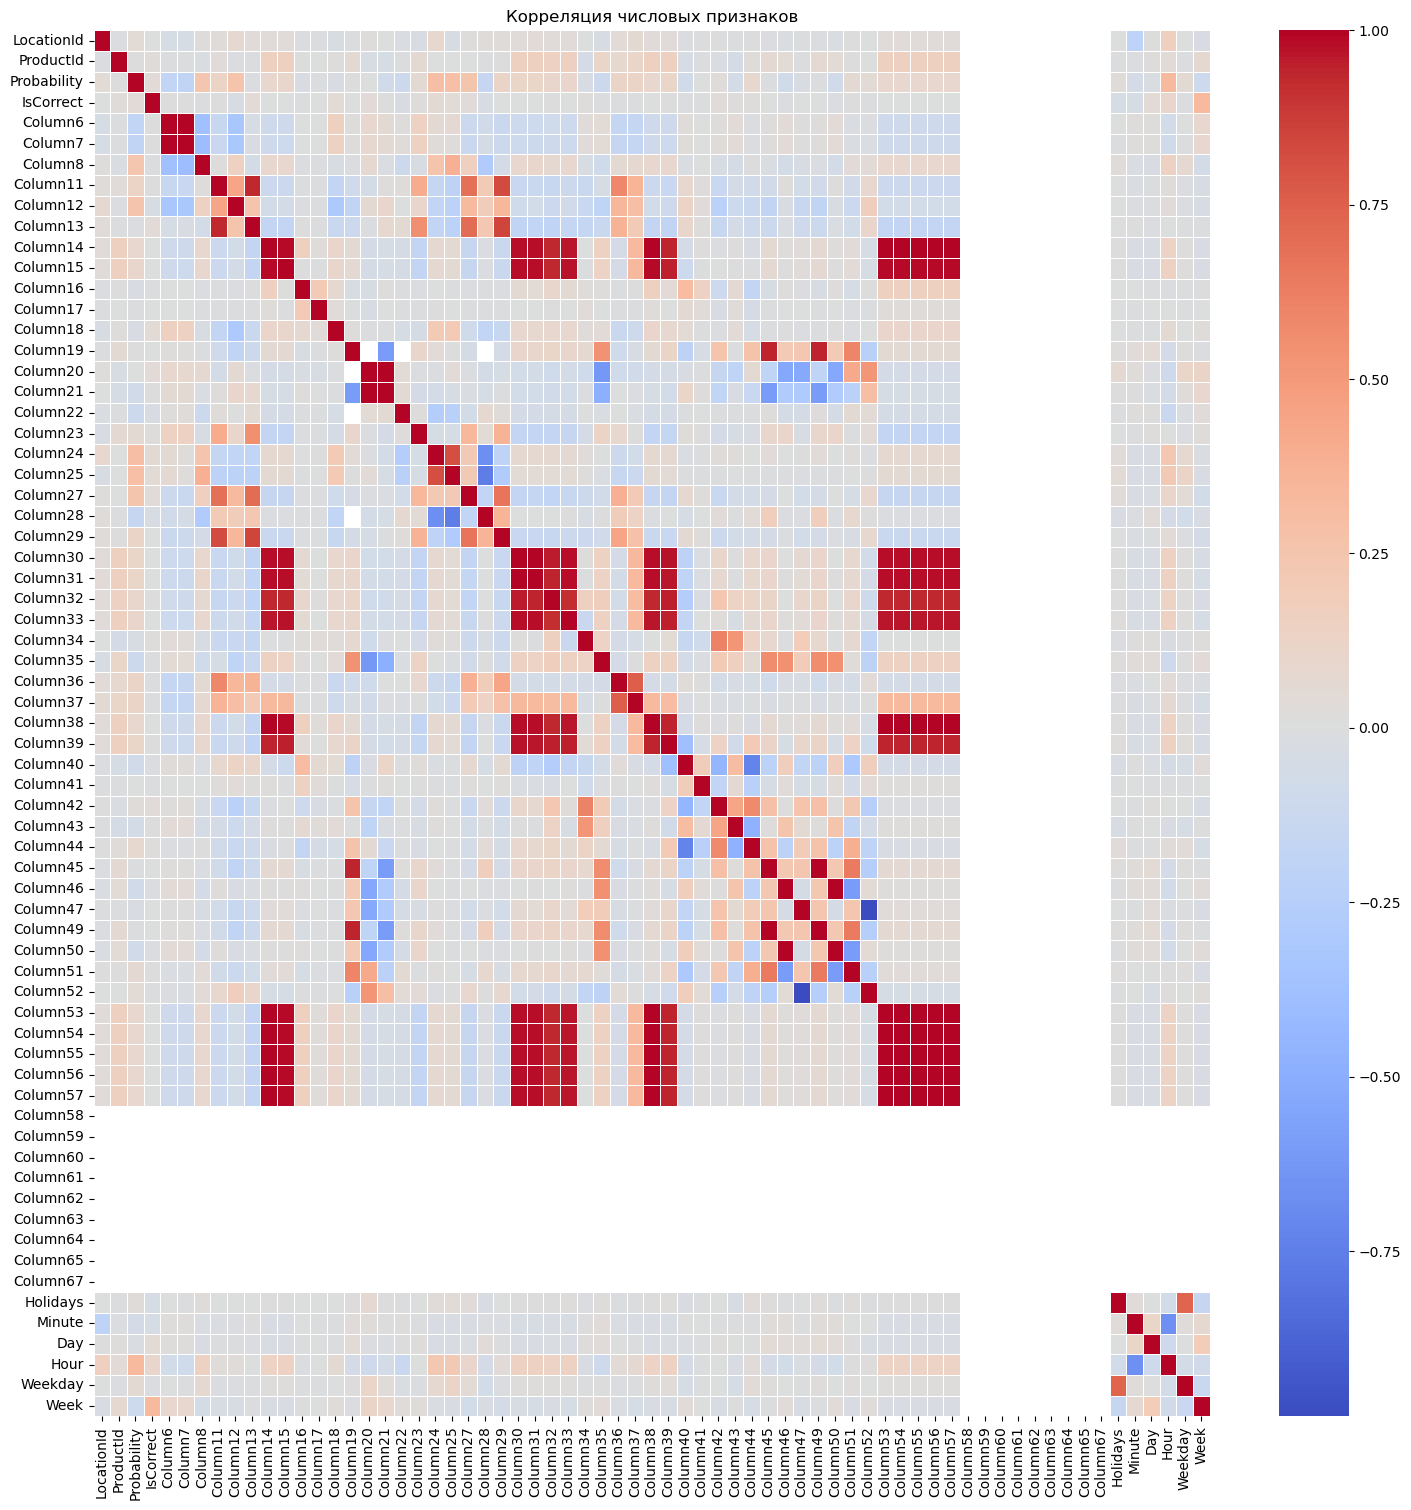

In [26]:
# кореляционная матрицу
corr_matrix = numeric.corr()
plt.figure(figsize=(18, 18))
# тепловая карта корреляций
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Корреляция числовых признаков')
plt.show()

## Направление 1 удалим столбец 'Probability'

In [27]:
df = df.drop(['Probability'], axis=1)
train_df = df[~df['IsCorrect'].isna()]

In [28]:
train_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,...,Column63,Column64,Column65,Column67,Holidays,Minute,Day,Hour,Weekday,Week
0,63,288527,2023-06-28,0.0,86.0,85.0,0.011628,0.142857,2,NaN,...,0.0,0.0,0.0,0.0,0,57,28,14,2,26
1,63,288606,2023-06-01,0.0,8.0,7.0,0.125000,3.714286,19,NaN,...,0.0,0.0,0.0,0.0,0,32,1,15,3,22
2,63,288606,2023-06-03,0.0,10.0,9.0,0.100000,3.214286,19,NaN,...,0.0,0.0,0.0,0.0,1,55,3,12,5,22
3,63,288606,2023-06-07,0.0,4.0,3.0,0.250000,3.178571,19,NaN,...,0.0,0.0,0.0,0.0,0,57,7,14,2,23
4,63,288606,2023-06-09,0.0,6.0,5.0,0.166667,3.035714,19,NaN,...,0.0,0.0,0.0,0.0,0,56,9,14,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176609,2950,574768,2023-07-19,1.0,0.0,-1.0,NaN,2.214286,8,NaN,...,0.0,0.0,0.0,0.0,0,1,19,15,2,29
176611,2950,575450,2023-06-20,0.0,1.0,0.0,1.000000,3.000000,25,NaN,...,0.0,0.0,0.0,0.0,0,0,20,15,1,25
176612,2950,576459,2023-07-02,0.0,41.0,40.0,0.024390,0.964286,8,NaN,...,0.0,0.0,0.0,0.0,1,1,2,15,6,26
176613,2950,576631,2023-07-12,1.0,1.0,0.0,1.000000,4.285714,27,NaN,...,0.0,0.0,0.0,0.0,0,17,12,15,2,28


# Заполним пропуски

In [29]:
# делим df на train_df и test_df
train_df = df[~df['IsCorrect'].isna()]
test_df = df[df['IsCorrect'].isna()]

In [30]:
# заменим пропуски на "заглушку 0"
train_df.fillna(0, inplace=True)

           proportion
IsCorrect            
0.0          0.770403
1.0          0.229597


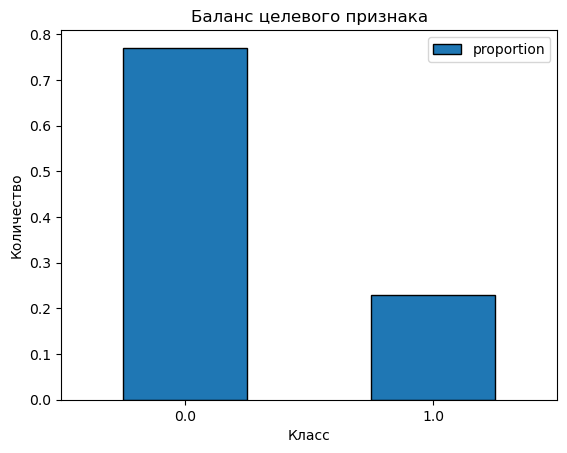

In [31]:
# оценим баланс целевого признака
class_frequency = train_df['IsCorrect'].value_counts(normalize=True).to_frame()
print(class_frequency)

ax = class_frequency.plot(kind='bar', rot=0, edgecolor='black', linewidth=1)
ax.set_xlabel('Класс')
ax.set_ylabel('Количество')
ax.set_title('Баланс целевого признака')
plt.show()

# Валидационная выборка

In [32]:
train_df['ValidationDateTime'] = pd.to_datetime(train_df['ValidationDateTime'])

In [33]:
# выборки 
valid_data = train_df.query('ValidationDateTime >= "2023-07-15"')
train_data = train_df.query('ValidationDateTime < "2023-07-15"')
# признаки
X_train = train_data.drop(['IsCorrect'], axis=1)    
X_valid = valid_data.drop(['IsCorrect'], axis=1)    
y_train = train_data['IsCorrect']  
y_valid = valid_data['IsCorrect']  

In [34]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_valid.shape, '\n', 'Целевой признак:', y_valid.shape, sep='')

Обучающая выборка
Признаки:(110912, 66)
Целевой признак:(110912,)
Тестовая выборка
Признаки:(24935, 66)
Целевой признак:(24935,)


# Модель "CatBoostClassifier"

In [35]:
columns = X_train.columns
columns

Index(['LocationId', 'ProductId', 'ValidationDateTime', 'Column6', 'Column7',
       'Column8', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column27', 'Column28',
       'Column29', 'Column30', 'Column31', 'Column32', 'Column33', 'Column34',
       'Column35', 'Column36', 'Column37', 'Column38', 'Column39', 'Column40',
       'Column41', 'Column42', 'Column43', 'Column44', 'Column45', 'Column46',
       'Column47', 'Column49', 'Column50', 'Column51', 'Column52', 'Column53',
       'Column54', 'Column55', 'Column56', 'Column57', 'Column58', 'Column59',
       'Column60', 'Column61', 'Column62', 'Column63', 'Column64', 'Column65',
       'Column67', 'Holidays', 'Minute', 'Day', 'Hour', 'Weekday', 'Week'],
      dtype='object')

In [36]:
columns = X_valid.columns
columns

Index(['LocationId', 'ProductId', 'ValidationDateTime', 'Column6', 'Column7',
       'Column8', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column27', 'Column28',
       'Column29', 'Column30', 'Column31', 'Column32', 'Column33', 'Column34',
       'Column35', 'Column36', 'Column37', 'Column38', 'Column39', 'Column40',
       'Column41', 'Column42', 'Column43', 'Column44', 'Column45', 'Column46',
       'Column47', 'Column49', 'Column50', 'Column51', 'Column52', 'Column53',
       'Column54', 'Column55', 'Column56', 'Column57', 'Column58', 'Column59',
       'Column60', 'Column61', 'Column62', 'Column63', 'Column64', 'Column65',
       'Column67', 'Holidays', 'Minute', 'Day', 'Hour', 'Weekday', 'Week'],
      dtype='object')

In [37]:
# кодируем признаки
cat = ['LocationId', 'ProductId', 'ValidationDateTime', 'Holidays', 'Hour', 'Weekday']
num = ['Column6', 'Column7',
       'Column8', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column27', 'Column28',
       'Column29', 'Column30', 'Column31', 'Column32', 'Column33', 'Column34',
       'Column35', 'Column36', 'Column37', 'Column38', 'Column39', 'Column40',
       'Column41', 'Column42', 'Column43', 'Column44', 'Column45', 'Column46',
       'Column47', 'Column49', 'Column50', 'Column51', 'Column52', 'Column53',
       'Column54', 'Column55', 'Column56', 'Column57', 'Column58', 'Column59',
       'Column60', 'Column61', 'Column62', 'Column63', 'Column64', 'Column65',
       'Column67']
enc = TargetEncoder(target_type='continuous', smooth='auto', random_state=RANDOM_STATE)
X_tr_enc = pd.DataFrame(enc.fit_transform(X_train[cat], y=y_train),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_train[cat].index)
X_vl_enc = pd.DataFrame(enc.transform(X_valid[cat]),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_valid[cat].index)
scaler = StandardScaler()
X_tr_sc = pd.DataFrame(scaler.fit_transform(X_train[num]), columns=scaler.get_feature_names_out(X_train[num].columns), 
    index = X_train[num].index)
X_vl_sc = pd.DataFrame(scaler.fit_transform(X_valid[num]), columns=scaler.get_feature_names_out(X_valid[num].columns), 
    index = X_valid[num].index)
X_train = pd.concat([X_tr_enc, X_tr_sc], axis=1)
X_valid = pd.concat([X_vl_enc, X_vl_sc], axis=1)

In [38]:
%%time
# категориальные и числовые признаки
categorical_columns = list(X_train.select_dtypes(include='object').columns)
num_features = list(X_train.select_dtypes(exclude='object').columns)

# модель CatBoostClassifier
model_cb = CatBoostClassifier(
    random_state=RANDOM_STATE,
    loss_function='Logloss',
    verbose=False,
    class_weights=[0.229597, 0.770403],
    cat_features=categorical_columns
)

# параметры для подбора
parameters_cb = {
    'learning_rate': [0.1, 0.5, 0.8],
    'depth': [6, 8, 10],
    'iterations': [30, 50, 100]
}

# cv для подбора параметров
cb = GridSearchCV(
    estimator=model_cb,
    param_grid=parameters_cb,
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

# обучение 
cb.fit(X_train, y_train)
best_cb_model = cb.best_estimator_

# прогноз на тестовой выборке
y_pred_valid_cb = best_cb_model.predict(X_valid)

# Расчет метрик
roc_auc_valid = roc_auc_score(y_valid, y_pred_valid_cb)
accuracy_valid = accuracy_score(y_valid, y_pred_valid_cb)
recall_valid = recall_score(y_valid, y_pred_valid_cb)
precision_valid = precision_score(y_valid, y_pred_valid_cb)
f1_valid = f1_score(y_valid, y_pred_valid_cb)

# Вывод результатов
print('\033[1m' + 'Модель "CatBoostClassifier"' + '\033[0m')
print('=' * 40)
print('\033[1m' + 'Лучший ROC-AUC на тренировочных данных:' + '\033[0m', cb.best_score_)
print('\033[1m' + 'ROC-AUC на валидных данных:' + '\033[0m', roc_auc_valid)
print('\033[1m' + 'Accuracy на валидных данных:' + '\033[0m', accuracy_valid)
print('\033[1m' + 'Recall на валидных данных:' + '\033[0m', recall_valid)
print('\033[1m' + 'Precision на валидных данных:' + '\033[0m', precision_valid)
print('\033[1m' + 'F1-мера на валидных данных:' + '\033[0m', f1_valid)
print('=' * 40)
print("Лучшие параметры:", cb.best_params_)
print('=' * 40)

Модель "CatBoostClassifier"
Лучший ROC-AUC на тренировочных данных: 0.8691455350773925
ROC-AUC на валидных данных: 0.6871455803413511
Accuracy на валидных данных: 0.6905955484259073
Recall на валидных данных: 0.7753763025858742
Precision на валидных данных: 0.6764309764309764
F1-мера на валидных данных: 0.7225319187196547
Лучшие параметры: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
CPU times: total: 21.5 s
Wall time: 2min 36s


# Метрики на валидной выборке

In [39]:
# результат
index_result =['Лучший ROC-AUC на тренировочных данных',
               'ROC-AUC на валидных данных',
               'Accuracy на валидных данных',
               'Recall на валидных данных',
               'Precision на валидных данных',
               'F1-мера на валидных данных']

data_result = {
    'CatBoostClassifier': [
        cb.best_score_,
        roc_auc_valid,
        accuracy_valid,
        recall_valid,
        precision_valid,
        f1_valid
    ]
}
result = pd.DataFrame(data_result, index=index_result)
result.index.name = 'Метрика'
result

,CatBoostClassifier
Метрика,
Лучший ROC-AUC на тренировочных данных,0.869146
ROC-AUC на валидных данных,0.687146
Accuracy на валидных данных,0.690596
Recall на валидных данных,0.775376
Precision на валидных данных,0.676431
F1-мера на валидных данных,0.722532


# Построим кривую AUC-ROC для лучшей модели

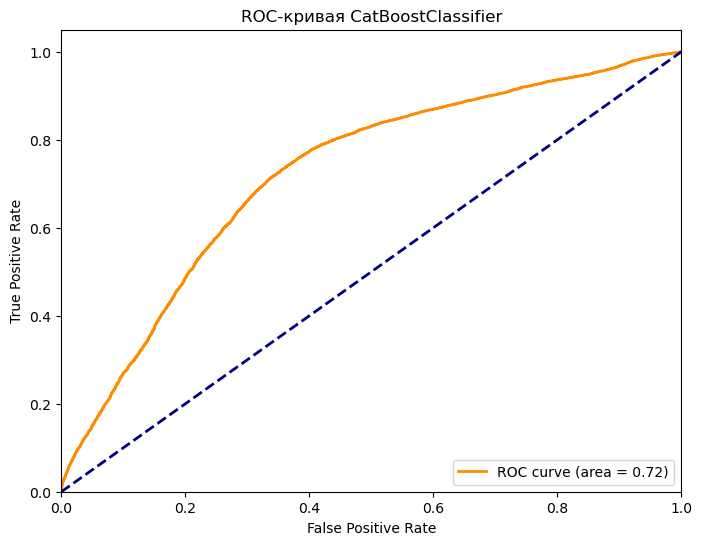

In [40]:
# предсказанных вероятностей класса 1
y_pred_proba = best_cb_model.predict_proba(X_valid)[:, 1]

# передаем на вход значения целевого признака и вероятности положительного класса
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

# вычисление значения AUC
roc_auc = auc(fpr, tpr)

# строим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая CatBoostClassifier')
plt.legend(loc="lower right")
plt.show()

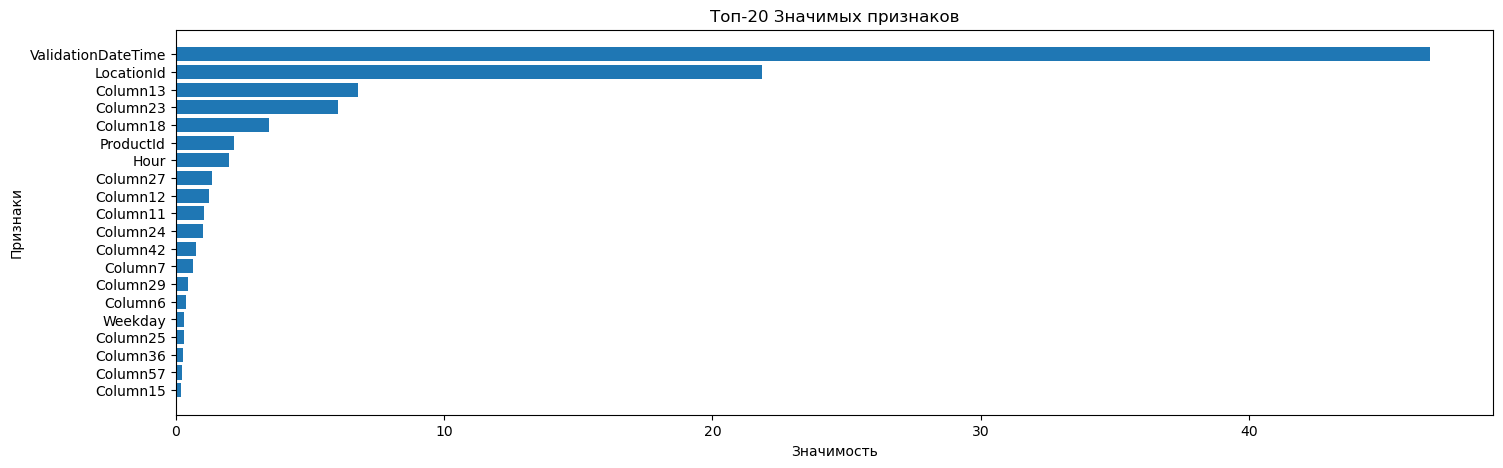

In [41]:
# получим признаки
importance = best_cb_model.feature_importances_
feature_names = X_train.columns

# сортируем признаки по значимости
sorting_indices = np.argsort(importance)[::-1] 
top_n = 20  # количество признаков для вывода

sorting_importance = importance[sorting_indices][:top_n]
sorting_feature_names = feature_names[sorting_indices][:top_n]

# визуализируем
plt.figure(figsize=(17, 5))
plt.barh(range(len(sorting_importance)), sorting_importance)
plt.yticks(range(len(sorting_importance)), sorting_feature_names)
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.title('Топ-20 Значимых признаков')
plt.gca().invert_yaxis()
plt.show()

# Получение вероятностей и выгрузка для test_df

In [42]:
# признаки для выгрузки вероятностей test_df
X_train = train_df.drop(['IsCorrect'], axis=1)    
X_valid = test_df.drop(['IsCorrect'], axis=1)    
y_train = train_df['IsCorrect']  
y_valid = test_df['IsCorrect'] 

In [43]:
# кодируем признаки
cat = ['LocationId', 'ProductId', 'ValidationDateTime', 'Holidays', 'Hour', 'Weekday']
num = ['Column6', 'Column7',
       'Column8', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column27', 'Column28',
       'Column29', 'Column30', 'Column31', 'Column32', 'Column33', 'Column34',
       'Column35', 'Column36', 'Column37', 'Column38', 'Column39', 'Column40',
       'Column41', 'Column42', 'Column43', 'Column44', 'Column45', 'Column46',
       'Column47', 'Column49', 'Column50', 'Column51', 'Column52', 'Column53',
       'Column54', 'Column55', 'Column56', 'Column57', 'Column58', 'Column59',
       'Column60', 'Column61', 'Column62', 'Column63', 'Column64', 'Column65',
       'Column67']
enc = TargetEncoder(target_type='continuous', smooth='auto')
X_tr_enc = pd.DataFrame(enc.fit_transform(X_train[cat], y=y_train),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_train[cat].index)
X_vl_enc = pd.DataFrame(enc.transform(X_valid[cat]),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_valid[cat].index)
scaler = StandardScaler()
X_tr_sc = pd.DataFrame(scaler.fit_transform(X_train[num]), columns=scaler.get_feature_names_out(X_train[num].columns), 
    index = X_train[num].index)
X_vl_sc = pd.DataFrame(scaler.fit_transform(X_valid[num]), columns=scaler.get_feature_names_out(X_valid[num].columns), 
    index = X_valid[num].index)
X_train = pd.concat([X_tr_enc, X_tr_sc], axis=1)
X_valid = pd.concat([X_vl_enc, X_vl_sc], axis=1)

In [44]:
# категориальные и числовые признаки
categorical_columns = list(X_train.select_dtypes(include='object').columns)
num_features = list(X_train.select_dtypes(exclude='object').columns)

# модель CatBoostClassifier
model_cb = CatBoostClassifier(
    random_state=RANDOM_STATE,
    loss_function='Logloss',
    verbose=False,
    class_weights=[0.229597, 0.770403],
    cat_features=categorical_columns
)

# параметры для подбора
parameters_cb = {
    'learning_rate': [0.1, 0.5, 0.8],
    'depth': [6, 8, 10],
    'iterations': [30, 50, 100]
}

# cv для подбора параметров
cb = GridSearchCV(
    estimator=model_cb,
    param_grid=parameters_cb,
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

# обучение 
cb.fit(X_train, y_train)

best_cb_model = cb.best_estimator_

# прогноз на тестовой выборке
y_pred_valid_cb = best_cb_model.predict(X_valid)

In [45]:
predicted_probabilities = best_cb_model.predict_proba(X_valid)
# вероятности для класса 1 
calculated_probabilities = predicted_probabilities[:, 1]
calculated_probabilities

array([0.87851619, 0.68179493, 0.77516037, ..., 0.61768756, 0.62503959,
       0.63198431])

In [46]:
test_df['CalculatedProbability'] = calculated_probabilities
checkpoint = test_df[['LocationId','ProductId','ValidationDateTime','CalculatedProbability']]

In [47]:
checkpoint = checkpoint.sort_values(by='ValidationDateTime')
checkpoint

,LocationId,ProductId,ValidationDateTime,CalculatedProbability
157534,2763,310892,2023-07-22,0.925111
100600,1927,496498,2023-07-22,0.558834
163062,2811,413140,2023-07-22,0.164077
11066,263,563236,2023-07-22,0.665030
121905,2354,309093,2023-07-22,0.547711
...,...,...,...,...
160975,2799,413141,2023-08-04,0.273348
127827,2489,469692,2023-08-04,0.671671
87671,1717,425652,2023-08-04,0.810552
161017,2799,420893,2023-08-04,0.206009


In [48]:
checkpoint.to_csv('checkpoint.csv', index=False, sep=';')

# Вывод 

1. Загружены и изученны данные о товарах
2. Данные представлены в зашифрованном виде
3. Проведен первичный исследовательский анализ
- обнаружены пропуски и отсутвующие значения
- природа пропусков не ясна, принято решение заполнить нулевыми значениями
4. Дополнительно сформированы признаки: 
- 'Holidays' - является ли день праздничным или выходным
- 'Weekday' - номер дня недели
- 'Hour' - час, когда были полученны данные
5. Признаки разделны на категориальные и численные, закодированы TargetEncoder
6. Использованна моедель **CatBoostClassifier**
7. Параметры моедли подобранны с помощью **GridSearchCV**
8. Лучшая модель: параметры: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}
9. В топ-20 значимых признаков вошил вновь сформированные 'Hour' - час и "Weekday" - день недели, когда были полученны данные

**РЕЗУЛЬТАТ ROC-AUC** 
1. На валидных данных: 0.687
2. На чек-поинте = 0,722